In [47]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
%matplotlib inline

In [2]:
clean_data = pd.read_csv("clean_data.csv")

In [3]:
clean_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CAPS1', 'CAPS2', 'CAPS3', 'CAPS4',
       'CAPS5', 'CAPS6', 'CAPS7', 'Obscenity1', 'Obscenity2', 'Obscenity3',
       'Obscenity4', 'Obscenity5', 'Obscenity6', 'Obscenity7', 'Threat1',
       'Threat2', 'Threat3', 'Threat4', 'Threat5', 'Threat6', 'Threat7',
       'Tweet', 'hatespeech1', 'hatespeech2', 'hatespeech3', 'hatespeech4',
       'hatespeech5', 'hatespeech6', 'hatespeech7', 'namecalling1',
       'namecalling2', 'namecalling3', 'namecalling4', 'namecalling5',
       'namecalling6', 'namecalling7', 'negprejudice1', 'negprejudice2',
       'negprejudice3', 'negprejudice4', 'negprejudice5', 'negprejudice6',
       'negprejudice7', 'noneng1', 'noneng2', 'noneng3', 'noneng4', 'noneng5',
       'noneng6', 'noneng7', 'porn1', 'porn2', 'porn3', 'porn4', 'porn5',
       'porn6', 'porn7', 'stereotypes1', 'stereotypes2', 'stereotypes3',
       'stereotypes4', 'stereotypes5', 'stereotypes6', 'stereotypes7',
       'clean_tweet', 'ID'],
      dtype='ob

In [4]:
train = pd.read_csv("train.csv")

In [5]:
#there are dupes in the training set?

In [6]:
train = clean_data.merge(train[['ID']], on = "ID", how = 'inner')

In [7]:
train.loc[1:10,['Tweet', 'clean_tweet']]

,Tweet,clean_tweet
1,RT @Wilderness: .@SecretaryJewell is opening t...,opening outdoors underprivileged kids honor la...
2,"RT @PMOIndia: All our people, Hindus, Muslims,...",people hindus muslims sikhs christians jains b...
3,RT @AVISKINSWEAT: Being non black and having c...,non black close relationships black people mak...
4,Needs and Concerns of Family Caregivers of Ame...,needs concerns family caregivers american indi...
5,.I wonder how many African-American students a...,wonder many africanamerican students classes a...
6,RT @zeynaiman: Laying in my girlfriend's bed w...,laying girlfriends bed watching ted cruz pasto...
7,RT @homeIwt: Michael Jackson // African-Americ...,michael jackson africanamerican best artist ti...
8,@EDinCali @WBVT_98FM @CNN @CBC @CJAD800 @stati...,98fm aroud cuba 18 african latin american nati...
9,All I wanna do is work in impoverished countri...,wan na work impoverished countries fascinate
10,RT @joanwalsh: The misogyny from @realDonaldTr...,misogyny combined w misogyny leftwing haters t...


In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

In [9]:
train.loc[train['clean_tweet'].isnull(), 'Tweet']

29       https://t.co/MjOdG9SB3e https://t.co/ntSpKgYfTC 
526     @BryanFrench69 @Lying2yourselfe @charliesecho ...
580                              https://t.co/vBJe0lecJh 
582              RT @homenkovich: http://t.co/FvhAYrzs2m 
1058    https://t.co/H8TcpYOsVb... https://t.co/gEiolF...
1172                             https://t.co/ALJrEx96Nt 
2552    @Jnoubiii12 @iShabi7a @ShahTalks https://t.co/...
3178            RT @DuffMcKagan: https://t.co/bjXmca2AO3 
Name: Tweet, dtype: object

In [10]:
train = train.loc[train['clean_tweet'].isnull() == False, :]

In [11]:
features = tfidf.fit_transform(train['clean_tweet']).toarray()

### Create Non-English Label

In [57]:
train['num_noneng'] = \
train[['noneng1', 'noneng2', 'noneng3', 'noneng4', 'noneng5', 'noneng6', 'noneng7']]\
.sum(axis = 1)

train['noneng'] = train['num_noneng'] > 1

train['noneng'].value_counts()

labels = train['noneng']

### Compare Logistic Regression to Linear SVC

In [22]:
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

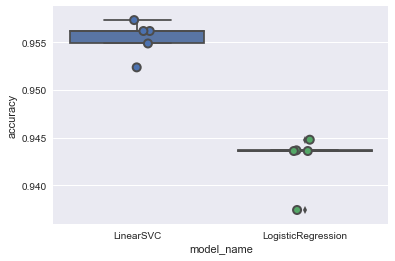

In [25]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.955400
LogisticRegression    0.942622
Name: accuracy, dtype: float64

### Get Confusion Matrix for Linear SVM predicting Non-English

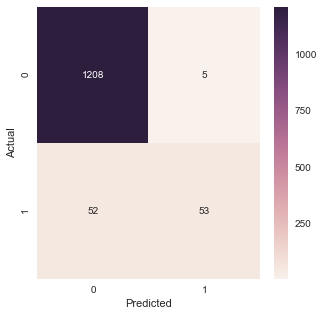

In [60]:
model = LinearSVC()
labels = train.noneng
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
f1_score(y_test, y_pred)

0.6503067484662578

### Create Hatespeech Label

In [54]:
train['num_hatespeech'] = \
train[['hatespeech1', 'hatespeech2', 'hatespeech3', 'hatespeech4', 'hatespeech5', 'hatespeech6', 'hatespeech7']]\
.sum(axis = 1)

train['hatespeech'] = train['num_hatespeech'] > 1

train['hatespeech'].value_counts()

labels = train['hatespeech']

### Get Confusion Matrix for Linear SVM Predicting Hate Speech

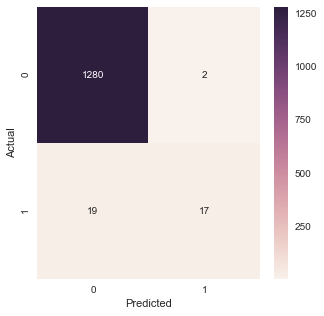

In [62]:
model = LinearSVC()
labels = train.hatespeech
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [63]:
f1_score(y_test, y_pred)

0.61818181818181817

In [ ]:
#this is promising for how simple the model was and how little tuning we did

In [ ]:
#followed this tutorial for convenience: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f